In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm

from tqdm.auto import tqdm

plt.style.use('ggplot')
%matplotlib inline

## Задание
### А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

In [84]:
df = pd.read_csv('hw_aa.csv', sep=';')

In [85]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


## Проведем АА тест

In [86]:
df[df.experimentVariant == 0].purchase
df[df.experimentVariant == 1].purchase

0         0
2         0
3         0
4         0
5         0
         ..
127009    0
127010    0
127015    0
127016    0
127017    0
Name: purchase, Length: 63916, dtype: int64

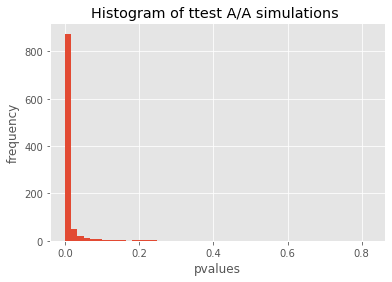

0.944

In [87]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## По результатам АА теста можно сделать вывод, что сплит система нарушена и надо искать причины

In [13]:
df.value_counts('version')

version
v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
dtype: int64

In [80]:
df.groupby(['version', 'purchase'], as_index = False).agg({'experimentVariant': ['sum', 'count', 'mean']})

version purchase experimentVariant                 
                                   sum  count      mean
0    v2.8.0        0             39657  80899  0.490204
1    v2.8.0        1              1895   1936  0.978822
2    v2.9.0        0             11175  22206  0.503242
3    v2.9.0        1               858   1748  0.490847
4  v3.7.4.0        0              3955   7907  0.500190
5  v3.7.4.0        1               266    518  0.513514
6  v3.8.0.0        0              5726  11092  0.516228
7  v3.8.0.0        1               384    712  0.539326

## В полученном датафрейме можем заменить неправильное деление пользователей с версией v2.8.0 которые совершали покупку. Значительная часть пользователей отдана одной группе.

## Проведем АА тест исключив пользователей с версией v2.8.0

In [31]:
df.query('version != "v2.8.0" and experimentVariant == 0').purchase

1         0
6         0
17        0
33        1
38        1
         ..
126992    0
126993    0
126994    0
126996    0
127002    0
Name: purchase, Length: 21819, dtype: int64

In [30]:
df.query('version != "v2.8.0" and experimentVariant == 1').purchase

2         0
10        0
13        0
15        0
34        1
         ..
126977    0
126985    0
126991    0
127003    0
127015    0
Name: purchase, Length: 22364, dtype: int64

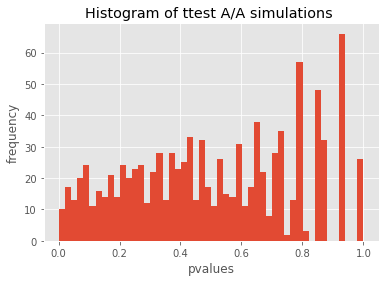

0.032

In [32]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('version != "v2.8.0" and experimentVariant == 0').purchase.sample(n_s, replace = False).values
    s2 = df.query('version != "v2.8.0" and experimentVariant == 1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## В результате, удалив пользователей с версией v2.8.0, мы получили статистически незначимо различающиеся выборки, что в свою очередь говорит о правильном разбиении пользователей

## Вывод

### Поломка сплит системы заключается в неправильном разбиении пользователей которые совершили покупку с версией v2.8.0

#### P.s. Так как пользователей с версией v2.8.0 больше половины из всех, чтоб хоть как-то сохранить объем данных, попробуем удалить не всех пользователей с версией v2.8.0, а только тех, которые совершили покупку.

In [73]:
dfe = df[(df.version == 'v2.8.0') & (df.purchase == 1)]

In [74]:
dfe

,Unnamed: 0,uid,experimentVariant,version,purchase
35,36,19ca14e7ea6328a42e0eb13d585e4c22,1,v2.8.0,1
54,55,b53b3a3d6ab90ce0268229151c9bde11,1,v2.8.0,1
58,59,093f65e080a295f8076b1c5722a46aa2,1,v2.8.0,1
64,65,fc490ca45c00b1249bbe3554a4fdf6fb,1,v2.8.0,1
70,71,e2c420d928d4bf8ce0ff2ec19b371514,1,v2.8.0,1
...,...,...,...,...,...
126528,126529,62ffe1b02c577406eab799a337fccf4a,1,v2.8.0,1
126529,126530,d794151773593bc9cd8b795f8afbecf9,1,v2.8.0,1
126684,126685,1bc2614c1175d7346deacbf87a4a27ba,1,v2.8.0,1
126685,126686,4f3244fc8b8787fe45c90c2a41c28478,1,v2.8.0,1


In [77]:
df_correct = df.merge(dfe, on=['Unnamed: 0', 'uid', 'experimentVariant', 'version', 'purchase'], how='outer', indicator = True).query('_merge=="left_only"')

In [78]:
df_correct

,Unnamed: 0,uid,experimentVariant,version,purchase,_merge
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0,left_only
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0,left_only
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0,left_only
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0,left_only
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0,left_only
...,...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0,left_only
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0,left_only
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0,left_only
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0,left_only


In [ ]:
df_correct[df_correct.experimentVariant == 0].purchase
df_correct[df_correct.experimentVariant == 1].purchase

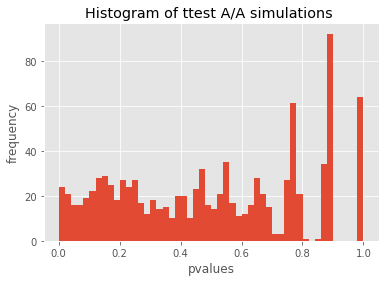

0.048

In [79]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_correct[df_correct.experimentVariant == 0].purchase.sample(n_s, replace = False).values
    s2 = df_correct[df_correct.experimentVariant == 1].purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## Вывод №2 
### Увидев результат можем сделать вывод, что удалив только тех пользователей с версией v2.8.0, которые совершили покупку, получим, как и в первом нашем варианте, статистически незначимо различающиеся выборки, притом, что в данном случае, объем данных получился примерно в 2 раза больше.